# НУЖНО ВЫБРАТЬ МЕТРИКУ И ОБУЧИТЬ МОДЕЛЬ

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn

folder_path = "data/20230904_segm_rat_OFT_gray_back/20230904_segm_rat_OFT_gray_back"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

cpu


In [5]:
# import os
# import pandas as pd

# train_images_folder = folder_path + "/test_images"
# train_masks_folder = folder_path + "/test_masks"

# train_images_files = os.listdir(train_images_folder)
# train_masks_files = os.listdir(train_masks_folder)

# image_paths = [os.path.join("test_images", file) for file in train_images_files]
# mask_paths = [os.path.join("test_masks", file) for file in train_masks_files]

# data = {'orig_image': image_paths, 'mask_image': mask_paths}
# df = pd.DataFrame(data)

# csv_file_path = "test_data.csv"

# df.to_csv(csv_file_path, index=False)

# print("CSV file created successfully!")

CSV file created successfully!


In [ ]:
def draw(orig_image, mask_image):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image')
    
    axes[1].imshow(mask_image)
    axes[1].set_title('Mask Image')

    plt.tight_layout()
    plt.show()

### Preprocessing (подготовка данных)

In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, folder, data, transform):
      self.folder = folder
      self.data = data.copy()
      self.orig_image_paths = [os.path.join(folder, filename) for filename in data['orig_image'].copy()]
      self.mask_image_paths = [os.path.join(folder, filename) for filename in data['mask_image'].copy()]
      self.transform = transform

    def __len__(self):
        return len(self.orig_image_paths)

    def __getitem__(self, idx):
        orig_image_path = self.orig_image_paths[idx]
        mask_image_path = self.mask_image_paths[idx]
        orig_image = Image.open(orig_image_path).convert('RGB')
        mask_image = Image.open(mask_image_path).convert('RGB')

        orig_image = self.transform(orig_image)
        orig_image = orig_image.to(orig_image)
        
        mask_image = self.transform(mask_image)
        mask_image = mask_image.to(mask_image)

        return orig_image.float(), mask_image.float()

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1 , random_state=42)

size = (224, 224)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
batch_size = 8

transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std)])

train_dataset = ImagesDataset(folder_path, train, transform)
val_dataset = ImagesDataset(folder_path, val, transform)
test_dataset = ImagesDataset(folder_path, test, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training/evaluation loop

In [ ]:
def learning(num_epochs, train_load, val_load, model, optimizer, criterion):
  model.to(device)

  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in tqdm(train_load):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_load))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_load):
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          val_loss += (loss.item())
    val_losses.append(val_loss/len(val_load))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
  return model, train_losses, val_losses

### Prediction function

In [ ]:
def prediction(model, loader):
  model.eval()
  predictions = []
  orig_images = []
  with torch.no_grad():
    for x_batch, y_batch in tqdm(loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        orig_images.append(outputs.cpu().numpy())
  predictions = np.concatenate(predictions, axis=0).flatten()
  orig_images = np.concatenate(orig_images, axis=0).flatten()
  return predictions, orig_images

In [ ]:
def validation(model, loader, images_to_draw):
    predictions, orig_images = prediction(model, loader)

    # выбрать метрику
    
    for i in range(images_to_draw):
        draw(orig_images[i], predictions[i])


### Experiments

In [ ]:
import torchvision
model = torchvision.models.get_model('googlenet', weights='DEFAULT')

100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch [1/40], Train loss: 9.4540, Val loss: 1.1760


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Epoch [2/40], Train loss: 1.8354, Val loss: 0.6199


100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Epoch [3/40], Train loss: 1.0202, Val loss: 0.3799


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch [4/40], Train loss: 0.2686, Val loss: 0.2542


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Epoch [5/40], Train loss: 0.1578, Val loss: 0.2579


100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Epoch [6/40], Train loss: 0.1101, Val loss: 0.2340


100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


Epoch [7/40], Train loss: 0.3029, Val loss: 0.8562


100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Epoch [8/40], Train loss: 0.5817, Val loss: 0.4602


100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Epoch [9/40], Train loss: 0.1738, Val loss: 0.2404


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Epoch [10/40], Train loss: 0.2270, Val loss: 0.1955


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch [11/40], Train loss: 0.1036, Val loss: 0.1922


100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Epoch [12/40], Train loss: 0.0612, Val loss: 0.1762


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epoch [13/40], Train loss: 0.2694, Val loss: 0.2681


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Epoch [14/40], Train loss: 0.2018, Val loss: 0.3363


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Epoch [15/40], Train loss: 0.0634, Val loss: 0.2346


100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


Epoch [16/40], Train loss: 0.0617, Val loss: 0.2180


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch [17/40], Train loss: 0.3631, Val loss: 0.1639


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epoch [18/40], Train loss: 0.1656, Val loss: 0.2724


100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


Epoch [19/40], Train loss: 0.1061, Val loss: 0.1684


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch [20/40], Train loss: 0.0591, Val loss: 0.1641


100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


Epoch [21/40], Train loss: 0.0581, Val loss: 0.2086


100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Epoch [22/40], Train loss: 0.0629, Val loss: 0.1725


100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


Epoch [23/40], Train loss: 0.0797, Val loss: 0.2565


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch [24/40], Train loss: 0.0581, Val loss: 0.2040


100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Epoch [25/40], Train loss: 0.0248, Val loss: 0.1954


100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


Epoch [26/40], Train loss: 0.0175, Val loss: 0.1627


100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Epoch [27/40], Train loss: 0.0201, Val loss: 0.1597


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Epoch [28/40], Train loss: 0.0179, Val loss: 0.1557


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Epoch [29/40], Train loss: 0.0180, Val loss: 0.1493


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Epoch [30/40], Train loss: 0.0262, Val loss: 0.1462


100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Epoch [31/40], Train loss: 0.0122, Val loss: 0.1693


100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Epoch [32/40], Train loss: 0.0444, Val loss: 0.1503


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Epoch [33/40], Train loss: 0.0132, Val loss: 0.1720


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Epoch [34/40], Train loss: 0.0630, Val loss: 0.1840


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch [35/40], Train loss: 0.0436, Val loss: 0.2255


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


Epoch [36/40], Train loss: 0.0226, Val loss: 0.2929


100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Epoch [37/40], Train loss: 0.1102, Val loss: 0.3982


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Epoch [38/40], Train loss: 0.1582, Val loss: 1.1704


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch [39/40], Train loss: 0.0980, Val loss: 0.1837


100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


Epoch [40/40], Train loss: 0.1148, Val loss: 0.1554


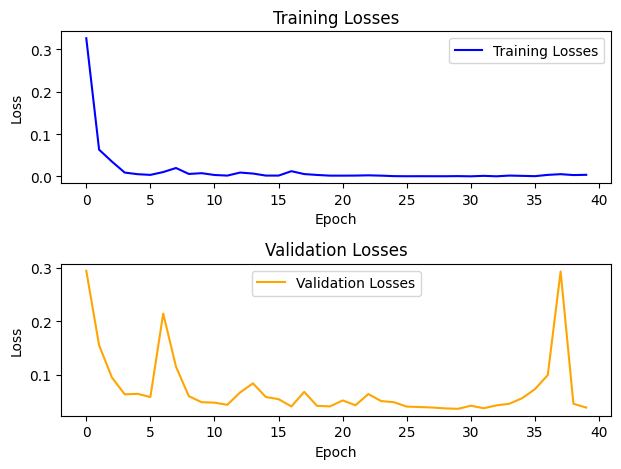

In [ ]:
model.fc = nn.Linear(1024, 1)

num_epochs = 40
learning_rate = 0.001
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

model, train_losses, val_losses = learning(num_epochs, train_loader, val_loader, model, optimizer, criterion)

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()
plt.tight_layout()
plt.show()

### Evaluation (оценка качества модели)

In [ ]:
validation(model, val_loader, 10)

In [ ]:
validation(model, test_loader, 10)